In [7]:
import re, json, requests
from pycoingecko import CoinGeckoAPI
from datetime import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

## Funções

In [11]:
def utc_to_timestamp(data):
    '''
    Get the date from the format dd/mm/yyyy and convert to timestamp
    '''
    #Get day, month, year
    data = data.split('/')
    day = re.sub('^0','',data[0])
    month = re.sub('^0','',data[1])
    year = data[2]

    #Put into the yyyy/mm/dd format
    date = datetime(int(year), int(month), int(day))

    #Remove decimal part
    
    return '{:.0f}'.format(datetime.timestamp(date))

def get_coingecko_price(coin1, coin2, data_ini, data_end):
    '''
    Download data from the cryptocompare api

    Keyword Arguments:\t
    coin1: Coin to compare price to coin 2\t
    coin2: Coin to compare price to coin 1\t
    data_ini: Initial Date\t
    data_end: Final date
    '''
    cg = CoinGeckoAPI()
    stamp_ini = utc_to_timestamp(data_ini)
    stamp_end = utc_to_timestamp(data_end)
    coin_data = cg.get_coin_market_chart_range_by_id(id=coin1, vs_currency=coin2, from_timestamp=stamp_ini, to_timestamp=stamp_end)
    coin_df = pd.DataFrame(coin_data['prices'], columns=['Datetime','Price'])
    coin_df['Datetime'] = pd.to_datetime(coin_df['Datetime'].astype(int), unit='ms')
    return coin_df
    

def get_cryptocompare_price(coin1, coin2, limit):
    '''
    Download data from the cryptocompare api

    Keyword Arguments:\t
    coin1: Coin to compare price to coin 2\t
    coin2: Coin to compare price to coin 1\t
    limit: Limit of values returned. Maximum of 2000.
    '''  
    endpoint = 'https://min-api.cryptocompare.com/data/histoday'
    res = requests.get(endpoint + '?fsym=' + coin1 + '&tsym=' + coin2 + '&limit=' + limit)
    hist = pd.DataFrame(json.loads(res.content)['Data'])
    hist = hist.set_index('time')
    hist.drop(columns=['conversionType', 'conversionSymbol'], inplace=True ,axis=1)
    hist.index = pd.to_datetime(hist.index, unit='s')
    pair = coin1 + '-' + coin2
    return hist, pair

## Price from CoinGeckoAPI 

In [9]:
df_coingecko = get_coingecko_price(coin1='bitcoin', coin2='usd', data_ini='01/01/2018', data_end = '29/06/2021')
df_coingecko

,Datetime,Price
0,2018-01-02,15321.932852
1,2018-01-03,15583.885538
2,2018-01-04,15976.365194
3,2018-01-05,18336.922980
4,2018-01-06,18343.662493
...,...,...
1270,2021-06-25,34675.449105
1271,2021-06-26,31943.136468
1272,2021-06-27,32023.973902
1273,2021-06-28,34607.293274


## Price from CryptoCompare API

In [151]:
df_cryptocompare, pair = get_cryptocompare_price('ETH','USD','1000')
df_cryptocompare.head(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2018-10-05,230.03,222.53,222.21,1281236.19,2.923406e+08,228.17
2018-10-06,227.29,223.99,228.17,1006198.60,2.264414e+08,225.05
2018-10-07,226.29,223.91,225.05,1071407.41,2.421631e+08,226.02
2018-10-08,230.49,226.24,226.03,1200418.82,2.751695e+08,229.23
2018-10-09,229.53,226.94,229.23,1188808.62,2.706553e+08,227.67


## Data pre-processing

In [152]:
#Indicate which variable we are using
df_cripto = df_cryptocompare.copy()
df_cripto

#Rename
df_cripto.index.rename("date", inplace=True)

#Get time period
time_period = df_cripto.index.to_list()

#Drop timestamp
#df_cripto.reset_index(drop=True, inplace=True)
df_cripto_dataset = df_cripto.astype(float)

#Feature Scaling
##For all independent variables
scaler = StandardScaler()
df_cripto_scaled = scaler.fit_transform(df_cripto_dataset)

In [153]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 1   # Number of days we want top predict into the future
n_past = 14    # Number of past days we want to use to predict the future

for i in range(n_past, len(df_cripto_scaled) - n_future +1):
    X_train.append(df_cripto_scaled[i - n_past:i, 0:df_cripto_dataset.shape[1]])
    y_train.append(df_cripto_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (987, 14, 6).
y_train shape == (987, 1).


## Model Training

In [154]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 14, 64)            18176     
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


In [155]:
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
56/56 [==============================] - 3s 19ms/step - loss: 0.0793 - val_loss: 18.9980
Epoch 2/10
56/56 [==============================] - 1s 14ms/step - loss: 0.0165 - val_loss: 1.5917
Epoch 3/10
56/56 [==============================] - 1s 14ms/step - loss: 0.0140 - val_loss: 1.6618
Epoch 4/10
56/56 [==============================] - 1s 14ms/step - loss: 0.0181 - val_loss: 0.5554
Epoch 5/10
56/56 [==============================] - 1s 13ms/step - loss: 0.0147 - val_loss: 0.2643
Epoch 6/10
56/56 [==============================] - 1s 13ms/step - loss: 0.0131 - val_loss: 0.3018
Epoch 7/10
56/56 [==============================] - 1s 14ms/step - loss: 0.0113 - val_loss: 0.1147
Epoch 8/10
56/56 [==============================] - 1s 14ms/step - loss: 0.0109 - val_loss: 0.2560
Epoch 9/10
56/56 [==============================] - 1s 13ms/step - loss: 0.0115 - val_loss: 0.4411
Epoch 10/10
56/56 [==============================] - 1s 14ms/step - loss: 0.0090 - val_loss: 0.2710


## Make Predictions

In [178]:
#We Start with the last day in training date.
n_future=90 #We redefine n_future to extend prediction dates beyond original n_future dates

forecast_period_dates = pd.date_range(list(time_period)[-1], periods=n_future, freq='1d').tolist()

forecast = model.predict(X_train[-n_future:]) #forecast 
predictions_train = model.predict(X_train[n_past:])

#Perform inverse transformation to rescale back to original range
forecast_copies = np.repeat(forecast, df_cripto_dataset.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,5] #Get the close price

In [179]:
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'close':y_pred_future})

original = df_cripto.reset_index().copy()
original = original[['date','close']]
original = original.loc[original['date'] >= '2020-1-1']

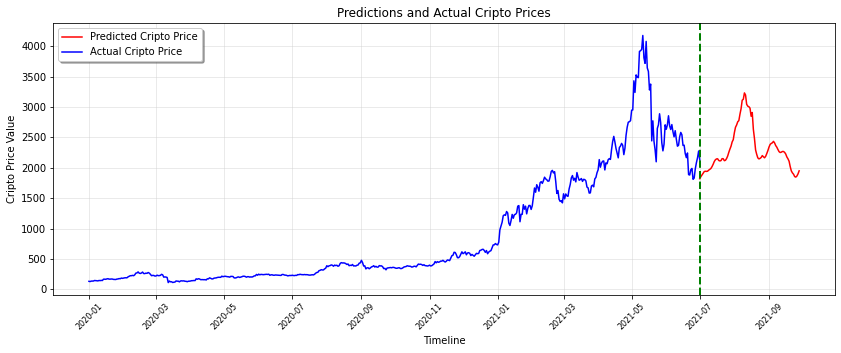

In [180]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2020-01-01'

plt.plot(df_forecast['date'], df_forecast['close'], color='r', label='Predicted Cripto Price')

plt.plot(original['date'], original['close'], color='b', label='Actual Cripto Price')

plt.axvline(x = min(df_forecast['date']), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predictions and Actual Cripto Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Cripto Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()